# 1. 설명
$RMSE = \sqrt{\frac{\Sigma_{i=1}^n(y_i-y)^2}{n}}$    

$NRMSE = RMSE/Mean$    

* 평가 산식: Normalizaed RMSE(NRMSE)
```
def lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(1,15): # ignore 'ID'
        rmse = metrics.mean_squared_error(gt[:,idx], preds[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:14])
    return score
```

# 2. 목표
* 공정 데이터를 활용하여 Radar 센서의 안테나 성능 예측을 위한 AI 모델 개발

# 3. 데이터
> 1. 학습(Train) 데이터셋 (39607개)   
> 파일명: train.csv   
> 설명: ID, X Feature(56개), Y Feature(14개)


> 2. 테스트(Test) 데이터셋 (39608개)   
> 파일명: test.csv   
> 설명: ID, X Feature(56개)   


> 3. sample_submission.csv (제출양식)   
> 설명 : ID, 예측한 Y Feature(14개)   

 
> 4. ./meta/x_feature_info.csv   
> 설명: 비식별화된 X Feature에 대한 세부 설명 자료   


> 5. ./meta/y_feature_info.csv    
> 설명 : 비식별화된 Y Feature에 대한 세부 설명 자료   


> 6. ./meta/y_feature_spec_info.csv

설명 : 각 샘플의 정상, 불량을 판정할 수 있는 Y Feature 별 스펙 기준 자료
실제 공정 과정에서의 데이터로, 대회 진행을 위해 해당 스펙 값들은 임의 조정된 상태입니다.
대회 진행 중 공개되는 스펙 값으로부터 정상/불량 판정 결과가 실제 공정에서의 정상/불량률과는 차이가 있습니다.


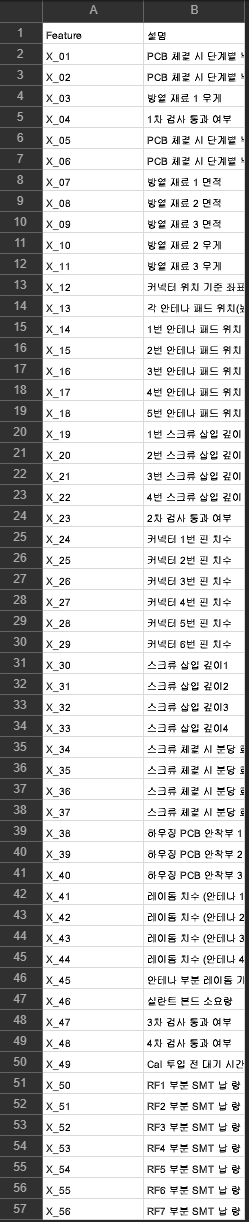

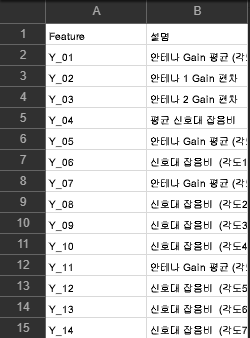

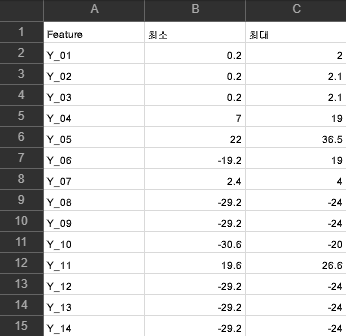

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import torch
import torch.nn as nn 
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

drive.mount('/content/drive/')

file_path = '/content/drive/My Drive/data/'

cuda
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
def seed_everything(seed):
  random.seed(seed)
   os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
seed_everything(42)

# Data Load

In [ ]:
train_csv = file_path + 'train.csv'
test_csv = file_path + 'test.csv'
submission_csv = file_path + 'sample_submission.csv'

train = pd.read_csv(train_csv)
test = pd.read_csv(test_csv)
submission = pd.read_csv(submission_csv)

In [ ]:
train.head()

,ID,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,...,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
0,TRAIN_00001,70.544,103.320,67.47,1,101.892,74.983,29.45,62.38,245.71,...,29.632,16.083,4.276,-25.381,-25.529,-22.769,23.792,-25.470,-25.409,-25.304
1,TRAIN_00002,69.524,103.321,65.17,1,101.944,72.943,28.73,61.23,233.61,...,33.179,16.736,3.229,-26.619,-26.523,-22.574,24.691,-26.253,-26.497,-26.438
2,TRAIN_00003,72.583,103.320,64.07,1,103.153,72.943,28.81,105.77,272.20,...,31.801,17.080,2.839,-26.238,-26.216,-22.169,24.649,-26.285,-26.215,-26.370
3,TRAIN_00004,71.563,103.320,67.57,1,101.971,77.022,28.92,115.21,255.36,...,34.503,17.143,3.144,-25.426,-25.079,-21.765,24.913,-25.254,-25.021,-25.345
4,TRAIN_00005,69.524,103.320,63.57,1,101.981,70.904,29.68,103.38,241.46,...,32.602,17.569,3.138,-25.376,-25.242,-21.072,25.299,-25.072,-25.195,-24.974


In [ ]:
test.head()

,ID,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,...,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
0,TEST_00001,68.504,103.321,76.67,1,101.867,73.963,30.51,63.57,239.80,...,1,1,17227.63,138.130429,129.460682,141.506570,133.427229,129.711498,133.138096,121.859684
1,TEST_00002,67.485,103.320,69.37,1,101.992,67.845,28.03,116.99,189.23,...,1,1,17134.53,136.148839,128.266277,145.911745,131.196417,132.411480,133.629025,124.178623
2,TEST_00003,69.524,103.320,68.97,1,101.884,77.022,29.65,205.68,214.93,...,1,1,14860.83,120.447446,119.988804,132.099908,120.450155,130.051708,128.252972,114.475628
3,TEST_00004,69.524,103.320,65.87,1,101.866,73.963,28.15,103.38,180.80,...,1,1,15252.53,133.994695,125.069180,147.507669,123.142653,125.963665,139.666592,126.589253
4,TEST_00005,73.603,103.321,66.67,1,101.891,74.983,29.92,71.20,231.93,...,1,1,10752.23,137.918202,135.116192,138.600473,127.173033,137.252712,134.411335,124.020016


In [ ]:
submission.head()

,ID,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
0,TEST_00001,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,TEST_00002,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,TEST_00003,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,TEST_00004,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,TEST_00005,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_x = train.filter(regex='X') # Input: X Feature
train_y = train.filter(regex='Y') # Output: Y Feature

In [ ]:
train_x

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10,...,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
0,70.544,103.320,67.47,1,101.892,74.983,29.45,62.38,245.71,0.0,...,1,1,9706.03,137.043591,135.359219,147.837968,134.313475,125.605427,136.721425,125.028256
1,69.524,103.321,65.17,1,101.944,72.943,28.73,61.23,233.61,0.0,...,1,1,10423.43,133.736691,135.979817,149.924692,123.630583,127.893337,143.322659,124.877308
2,72.583,103.320,64.07,1,103.153,72.943,28.81,105.77,272.20,0.0,...,1,1,10948.53,132.805112,131.055355,146.814592,128.939070,127.012195,140.395688,122.238232
3,71.563,103.320,67.57,1,101.971,77.022,28.92,115.21,255.36,0.0,...,1,1,15007.03,134.138760,133.239422,139.720132,132.260824,130.723186,147.624829,134.875225
4,69.524,103.320,63.57,1,101.981,70.904,29.68,103.38,241.46,0.0,...,1,1,11051.03,142.728970,136.620022,134.853555,134.760252,125.647793,139.331105,123.272762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39602,66.465,103.320,62.27,1,103.150,66.825,30.20,77.83,298.05,0.0,...,1,1,60630.73,129.965741,130.807148,133.481737,125.273130,121.780933,133.780110,129.029812
39603,66.465,103.321,62.77,1,102.021,66.825,29.21,102.25,270.67,0.0,...,1,1,60763.43,127.633885,120.158764,142.667802,122.465490,122.987209,143.090741,122.811413
39604,68.504,103.320,64.67,1,103.144,68.864,29.96,102.61,198.07,0.0,...,1,1,8813.33,132.501286,136.893025,134.419328,129.115431,130.920147,140.489232,119.166699
39605,66.465,103.320,63.67,1,102.025,67.845,30.30,112.60,275.52,0.0,...,1,1,62222.33,128.189679,121.495930,141.288011,130.141676,125.518825,136.603634,124.525929


In [ ]:
train_y

,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
0,2.056,1.456,1.680,10.502,29.632,16.083,4.276,-25.381,-25.529,-22.769,23.792,-25.470,-25.409,-25.304
1,1.446,1.184,1.268,18.507,33.179,16.736,3.229,-26.619,-26.523,-22.574,24.691,-26.253,-26.497,-26.438
2,1.251,0.665,0.782,14.082,31.801,17.080,2.839,-26.238,-26.216,-22.169,24.649,-26.285,-26.215,-26.370
3,1.464,1.079,1.052,16.975,34.503,17.143,3.144,-25.426,-25.079,-21.765,24.913,-25.254,-25.021,-25.345
4,0.983,0.646,0.689,15.047,32.602,17.569,3.138,-25.376,-25.242,-21.072,25.299,-25.072,-25.195,-24.974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39602,1.382,1.215,1.263,10.874,29.194,16.582,3.410,-26.486,-26.581,-22.772,24.261,-26.491,-26.584,-26.580
39603,1.482,0.606,1.083,8.759,29.859,15.659,3.406,-27.308,-27.203,-24.674,23.427,-27.250,-27.334,-27.325
39604,1.117,1.154,0.993,13.159,24.720,16.823,3.215,-26.502,-26.687,-22.577,24.301,-26.388,-26.425,-26.601
39605,0.895,0.187,0.477,9.123,26.412,15.757,4.216,-26.760,-26.634,-24.066,23.305,-26.536,-26.751,-26.635


# 모델 생성

In [ ]:
class NeuralNet(nn.Module):
  def __init__(self):
    super(NeuralNet, self).__init__()
    self.fc1 = nn.Linear(56, 512)
    self.layer1 = self.make_layers(512, num_repeat=300)
    self.relu = nn.ReLU(inplace=True)
    self.fc5 = nn.Linear(512, 14)

  
  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.layer1(x)
    x = nn.Dropout(0.2)(x)
    x = self.fc5(x)
    return x

  
  def make_layers(self, value, num_repeat):
    layers = []
    for _ in range(num_repeat):
      layers.append(nn.Linear(value, value))
      layers.append(nn.ReLU(inplace=True))
    
    return nn.Sequential(*layers)

In [ ]:
def numpy_to_tensor(variable):
  x = variable.values
  x = np.array(x, dtype=np.float32)
  x = torch.from_numpy(x)

  return x

def pandas_to_tensor(variable):
  return torch.tensor(variable.values)

def train_one_epoch(model, train_batch, criterion, optimizer, train_X, train_Y, device):
    model.train()
    train_loss = 0.0
    for i in range(train_batch):
        start = i * batch_size
        end = start + batch_size
        input = train_X[start:end].to(device, dtype=torch.float)
        label = train_Y[start:end].to(device, dtype=torch.float)

        input, label = input.to(device), label.to(device)
        outputs = model(input).squeeze() # # squeeze함수는 차원이 1인 차원을 제거해준다.
        loss = criterion(outputs, label)
        optimizer.zero_grad() # Gradients를 0으로 초기화
        loss.backward() # 역전파 계산
        optimizer.step() # 최적화과정 업데이트
        train_loss += loss.item() # train_loss 누적
    print(f"train_loss : {train_loss}")

def val_one_epoch(model, val_batch, criterion, val_X, val_Y, device):
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for i in range(val_batch):
            start = i * batch_size
            end = start + batch_size
            input = val_X[start:end].to(device, dtype=torch.float)
            label = val_Y[start:end].to(device, dtype=torch.float)

            input, label = input.to(device), label.to(device)
            outputs = model(input).squeeze() # squeeze함수는 차원이 1인 차원을 제거해준다.
            loss = criterion(outputs, label)
            val_loss += loss.item() # The item() method extracts the loss's value as a Python float.
    print(f"val_loss : {val_loss}")


def datapreparation(train_df):
    valset_ratio = 0.15 # 검증 데이터셋 비율
    train_df = train_df.sample(frac=1)

    train_df_X = train_df.filter(regex='X')
    train_df_Y = train_df.filter(regex='Y')

    valset_num = round(len(train_df_Y)*valset_ratio)

    val_df_X = pandas_to_tensor(train_df_X.iloc[:valset_num])
    val_df_Y = pandas_to_tensor(train_df_Y.iloc[:valset_num])    
    train_df_X = pandas_to_tensor(train_df_X.iloc[valset_num:])
    train_df_Y = pandas_to_tensor(train_df_Y.iloc[valset_num:])

    return train_df_X, train_df_Y, val_df_X, val_df_Y

In [ ]:
train_df_X, train_df_Y, val_df_X, val_df_Y = datapreparation(train)

### tensor를 gpu에 할당하는 3가지 방법 ("cuda" -> default cuda device (default gpu device))
```python
x = torch.tensor([1., 2.], device="cuda")    
x = torch.tensor([1., 2.]).cuda()    
x = torch.tensor([1., 2.]).to("cuda")    

print(x.device) # 할당된 device 정보 -> cuda:0
```

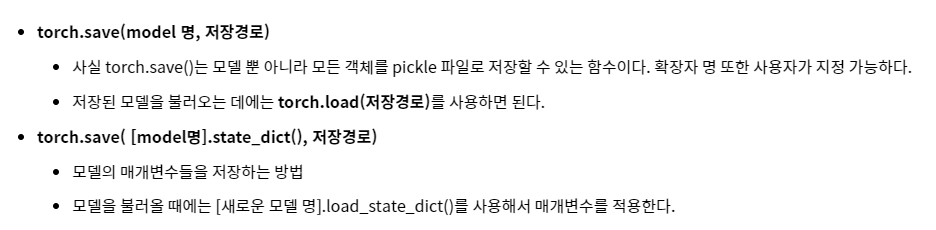

In [ ]:
model = NeuralNet()
print(model)
print(model.parameters())
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = 3e-4) # 가중치 최적화 방법(Adam)
criterion = nn.L1Loss().cuda() # 손실 함수 

epochs = 300
batch_size = 2048

train_batch = len(train_df_X) // batch_size
val_batch = len(val_df_X) // batch_size


for epoch in range(epochs):
  print(f"epoch: {epoch}")
  train_one_epoch(model, train_batch, criterion, optimizer, train_df_X, train_df_Y, device)
  val_one_epoch(model, val_batch, criterion, val_df_X, val_df_Y, device)

  torch.save(model.state_dict(), f'file_path + neuralnet.pt') # state_dict 는 간단히 말해 각 계층을 매개변수 텐서로 매핑되는 Python 사전(dict) 객체입니다.
  print("\n")

NeuralNet(
  (fc1): Linear(in_features=56, out_features=512, bias=True)
  (layer1): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): ReLU(inplace=True)
    (10): Linear(in_features=512, out_features=512, bias=True)
    (11): ReLU(inplace=True)
    (12): Linear(in_features=512, out_features=512, bias=True)
    (13): ReLU(inplace=True)
    (14): Linear(in_features=512, out_features=512, bias=True)
    (15): ReLU(inplace=True)
    (16): Linear(in_features=512, out_features=512, bias=True)
    (17): ReLU(inplace=True)
    (18): Linear(in_features=512, out_features=512, bias=True)
    (19): ReLU(inplace=

In [ ]:
model.eval()

NeuralNet(
  (fc1): Linear(in_features=56, out_features=512, bias=True)
  (layer1): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): ReLU(inplace=True)
    (10): Linear(in_features=512, out_features=512, bias=True)
    (11): ReLU(inplace=True)
    (12): Linear(in_features=512, out_features=512, bias=True)
    (13): ReLU(inplace=True)
    (14): Linear(in_features=512, out_features=512, bias=True)
    (15): ReLU(inplace=True)
    (16): Linear(in_features=512, out_features=512, bias=True)
    (17): ReLU(inplace=True)
    (18): Linear(in_features=512, out_features=512, bias=True)
    (19): ReLU(inplace=

In [ ]:
test_x = pd.read_csv(test_csv).drop(columns=['ID'])
test_x = torch.from_numpy(test_x.to_numpy()).to(device, dtype=torch.float)
result = model(test_x)

torch.Size([39608, 56])


OutOfMemoryError: ignored